### Load Modules

In [1]:
import sys, os
from tqdm import tqdm
import requests

path = os.path.dirname(os.path.abspath(os.getcwd()))
sys.path.insert(0, path+"\\.")
print('Please check the path below: \n')
print(path)

from src.data.utils import *

mapbox_token = 'pk.eyJ1IjoidXRrdWNhbm96dHVyayIsImEiOiJja3FzNHRsZWUxbW15Mm5zdGZmcTgwd2VhIn0.KR_U5sQadbUGPcCEU7YIpw'

data_path = os.path.join(path, 'data')

Please check the path below: 

c:\Users\ucn\Education\20211\InnoLab\gather-project


In [2]:
tile_size = .5 # in kilometers
image_pixel = 512

### Read Antananarivo Administrative level 2 boundaries

Data source: [The Humanitarian Data Exchange](https://data.humdata.org/dataset/madagascar-administrative-level-0-4-boundaries)

In [3]:
mgd_boundary = gp.read_file('../../data/mdg_adm_2')

**Filtering with the antananarivo area codes**

In [4]:
antananarivo_province = mgd_boundary[[i.startswith('MG1') for i in mgd_boundary.ADM1_PCODE]]
antananarivo_renivohitra = antananarivo_province[[i.startswith('MG1110100') for i in antananarivo_province.ADM2_PCODE]]

### Get grid of tiles for antananarivo

Creating grid of tiles...
Visualizing the grid...
Done!


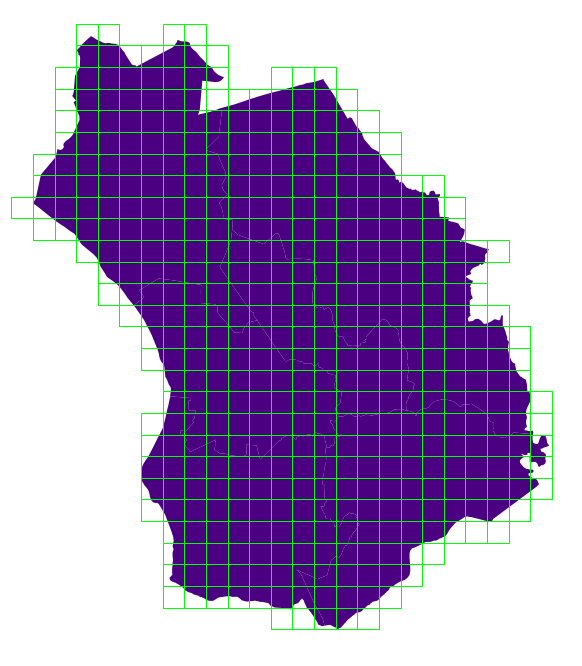

In [5]:
tiles = get_grid(antananarivo_renivohitra, tile_size, visualize = True)

### Get images and mask for the tiles

In [6]:
tile_bounds = tiles.loc[:,'geometry'].bounds.reset_index(drop = True)
tile_bounds = tile_bounds.apply(lambda x: x.astype(str)) 
tile_bounds['bounds'] = tile_bounds.agg(','.join, axis=1)

In [7]:
data_len = len(tile_bounds)
image_size = str(image_pixel) + 'x' + str(image_pixel)

print('Collecting data for ' + str(data_len) + ' tiles with the size of ' + image_size + '...')

for i in tqdm(range(data_len)):
     
     file_name = 'image_' + str(i+1).zfill(4) + '.png'
     
     # get mask
     url_mask = 'https://api.mapbox.com/styles/v1/utkucanozturk/ckzd87ivn001514p1frwhpxnr/static/[' + tile_bounds.loc[i, 'bounds'] + ']/' + image_size + '@2x?access_token=' + str(mapbox_token) + '&attribution=false&logo=false'
     response = requests.get(url_mask)
     
     # write mask
     with open(os.path.join(data_path, 'masks', file_name), 'wb') as output:
          _ = output.write(response.content)

     url_satellite = 'https://api.mapbox.com/styles/v1/mapbox/satellite-v9/static/[' + tile_bounds.loc[i, 'bounds'] + ']/' + image_size + '@2x?access_token=' + str(mapbox_token) + '&attribution=false&logo=false'
     response = requests.get(url_satellite)

     # write mask
     with open(os.path.join(data_path, 'images', file_name), 'wb') as output:
          _ = output.write(response.content)

  0%|          | 0/548 [00:00<?, ?it/s]

100%|██████████| 548/548 [08:37<00:00,  1.06it/s]
